In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from copy import deepcopy
from src.envs.darkroom import DarkroomEnv

# Load Model

In [19]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "darkroom_simple"

env_name = "darkroom_dim5_corr0.25_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.0_initseed2_batch1024"

model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)
eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/{wandb_project}/{env_name}/datasets/eval.pkl"


epoch=13-val_loss=0.911523.ckpt


In [20]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [21]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_2130669/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load dataset

In [22]:
n_eval_envs = 100

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [23]:
base_env_config = {
    'maze_dim': maze_dim,
    'horizon': 200,
    'state_dim': state_dim,
    'node_encoding_corr': node_encoding_corr,
    'initialization_seed': None, # will be overwritten
    'goal': None # will be overwritten
}

# Define test goals and trajectories in XY space
Goal location and long-path trajectories will be overwritten in each test environment, so that we can aggregate performance in an automated way

In [24]:
test_xy_goals = []
for i_eval in range(n_eval_envs):
    traj = eval_trajs[i_eval]
    base_env_config['initialization_seed'] = np.array(traj['initialization_seed']).item()
    base_env_config['goal'] = np.array(traj['goal'])
    env = DarkroomEnv(**base_env_config)
    xy_goal = env.node_map_encoding_to_pos[tuple(env.goal.tolist())]
    test_xy_goals.append(xy_goal)

print(np.unique(test_xy_goals, axis=0))

[[2 2]
 [3 0]]


In [25]:
test_xy_goals = np.unique(test_xy_goals, axis=0)
test_xy_trajectories = [
    [[0,0], [0,1], [1,1], [2,1], [3,1], [4,1], [4,2], [3,2], [2,2]],
    [[0,3], [1,3], [2,3], [3,3], [4,3], [4,2], [4,1], [4,0], [3,0]]
]
test_dist_from_goal = [4, 6]

# Helper Functions

In [26]:
def get_onestep_action(xy1, xy2):
    x1, y1 = xy1
    x2, y2 = xy2
    assert np.abs(x1-x2) + np.abs(y1-y2) <= 1
    if xy1 == xy2:
        return 4
    elif x1 < x2 and y1 == y2:
        return 2
    elif x1 > x2 and y1 == y2:
        return 0
    elif x1 == x2 and y1 < y2:
        return 1
    elif x1 == x2 and y1 > y2:
        return 3
    else:
        raise ValueError(f"Invalid action: {xy1} -> {xy2}")

In [27]:
def generate_trajectory_batch(xy_trajectory, xy_goal, env):
    context_states = []
    context_actions = []
    context_next_states = []
    context_rewards = []
    query_state = []
    for i in range(len(xy_trajectory)-1):
        state_feature = np.array(env.node_map_pos_to_encoding[tuple(xy_trajectory[i])])
        next_state_feature = np.array(env.node_map_pos_to_encoding[tuple(xy_trajectory[i+1])])
        action_idx = get_onestep_action(xy_trajectory[i], xy_trajectory[i+1])
        action = np.zeros(5)
        action[action_idx] = 1
        reward = 1 if np.all(xy_trajectory[i+1] == xy_goal) else 0
        context_states.append(state_feature)
        context_actions.append(action)
        context_next_states.append(next_state_feature)
        context_rewards.append(reward)
    context_states = np.array(context_states).squeeze()
    context_actions = np.array(context_actions)
    context_next_states = np.array(context_next_states).squeeze()
    context_rewards = np.array(context_rewards)
    batch = {
        'context_states': convert_to_tensor([context_states]),
        'context_actions': convert_to_tensor([context_actions]),
        'context_next_states': convert_to_tensor([context_next_states]),
        'context_rewards': convert_to_tensor([context_rewards[:, None]]),
    }
    return batch


# Run evaluation


In [28]:
results = {
    'test_idx': [],
    'i_eval': [],
    'success': [],
}

for test_idx in range(len(test_xy_goals)):
    test_xy_goal = test_xy_goals[test_idx]
    test_xy_trajectory = test_xy_trajectories[test_idx]
    dist_from_goal = test_dist_from_goal[test_idx]

    repeats = 1
    full_test_xy_trajectory = []

    for _ in range(repeats):
        full_test_xy_trajectory.extend(deepcopy(test_xy_trajectory))
        full_test_xy_trajectory.extend(deepcopy(test_xy_trajectory[:-1][::-1]))

    for i_eval in range(n_eval_envs):
        traj = eval_trajs[i_eval]
        base_env_config['initialization_seed'] = np.array(traj['initialization_seed']).item()
        base_env_config['goal'] = np.array(traj['goal'])
        env = DarkroomEnv(**base_env_config)
        env.goal = np.array(env.node_map_pos_to_encoding[tuple(test_xy_goal)])

        batch = generate_trajectory_batch(full_test_xy_trajectory, test_xy_goal, env)

        n_steps = dist_from_goal
        curr_xy_state = full_test_xy_trajectory[-1]
        query_state = env.node_map_pos_to_encoding[tuple(curr_xy_state)]
        returns = 0
        
        # Convert initial context tensors to numpy for easier concatenation
        context_states = batch['context_states'].cpu().numpy().squeeze()
        context_actions = batch['context_actions'].cpu().numpy().squeeze()
        context_next_states = batch['context_next_states'].cpu().numpy().squeeze()
        context_rewards = batch['context_rewards'].cpu().numpy().squeeze()
        
        for i in range(n_steps):
            batch = {
                'context_states': convert_to_tensor([context_states]),
                'context_actions': convert_to_tensor([context_actions]),
                'context_next_states': convert_to_tensor([context_next_states]),
                'context_rewards': convert_to_tensor([context_rewards[:, None]]),
                }
            batch['query_states'] = convert_to_tensor([np.array(query_state)])
            batch['query_states'] = batch['query_states'].to(model.device)
            batch['zeros'] = torch.zeros(1, state_dim ** 2 + 5 + 1).float()
            for k in batch.keys():
                batch[k] = batch[k].to(model.device)
        
            with torch.no_grad():
                out = model(batch)
        
            pred_action = torch.argmax(out.squeeze()).item()
            action_encoding = np.zeros(5)
            action_encoding[pred_action] = 1
            next_state_encoding, reward = env.transit(np.array(query_state), action_encoding)
        
            context_states = np.vstack([context_states, query_state])
            context_actions = np.vstack([context_actions, action_encoding])
            context_next_states = np.vstack([context_next_states, next_state_encoding])
            context_rewards = np.append(context_rewards, reward)
            query_state = next_state_encoding
            returns += reward

        results['test_idx'].append(test_idx)
        results['i_eval'].append(i_eval)
        results['success'].append(returns > 0)



<Axes: xlabel='test_idx', ylabel='success'>

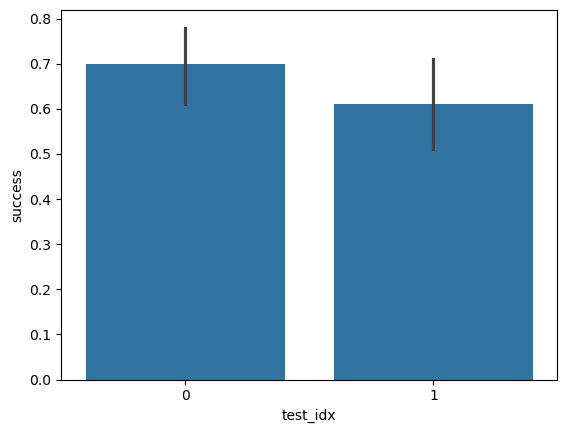

In [29]:
df = pd.DataFrame(results)
sns.barplot(data=df, x='test_idx', y='success')

In [17]:
print((1/env.action_dim)**4)
print((1/env.action_dim)**6)

0.0016000000000000003
6.400000000000002e-05
